In [1]:
import cv2
import glob
import mlflow
import random 
import os
from scipy import io
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.optimizers import *
from keras.models import *
from keras.layers import *
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from warnings import filterwarnings
filterwarnings(action='ignore')
from keras.applications import * 
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
from keras import regularizers

In [2]:
iterate = np.arange(0, 10000)
iterate = iter(iterate)

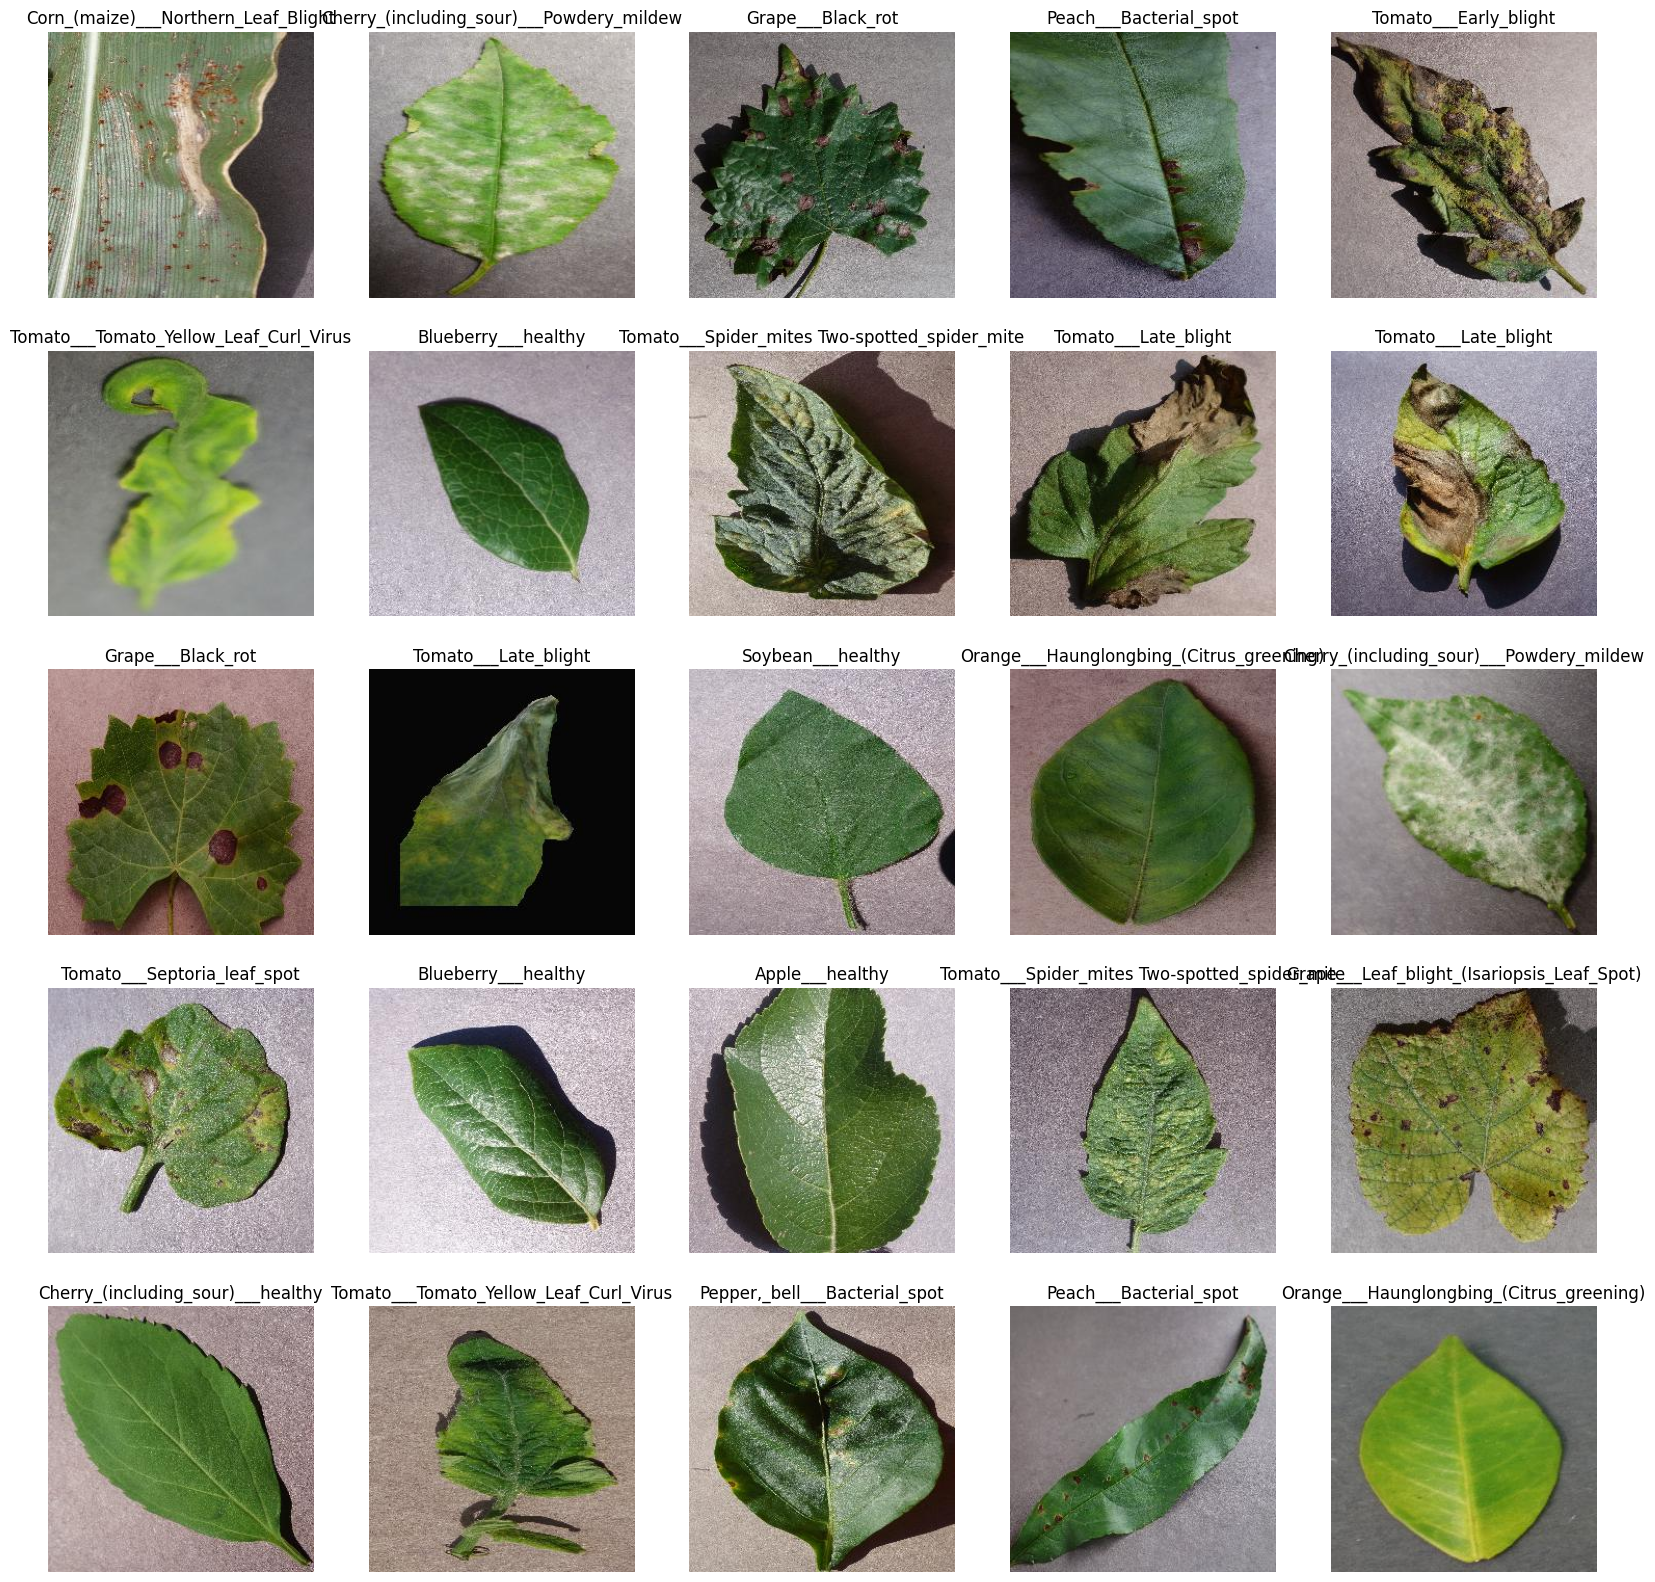

In [3]:
random_imgs = random.sample(glob.glob('plantvillage dataset/color/*/*'), 25)
fig, axes = plt.subplots(5, 5, figsize= (20, 20))
for i, ax in enumerate(axes.flatten()):
    ax.set_title(random_imgs[i].split('\\')[1])
    img = cv2.imread(random_imgs[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [4]:
classes = os.listdir('plantvillage dataset/color')
calss_dict = {item: index for index, item in enumerate(classes) }
labels = []
data = []
for i in glob.glob('plantvillage dataset/color/*/*'):
    labels.append(calss_dict[i.split('\\')[1]])
    data.append(i)

In [5]:
df = pd.DataFrame({'data': data, 'labels': labels})
df

data  labels
0      plantvillage dataset/color\Apple___Apple_scab\...       0
1      plantvillage dataset/color\Apple___Apple_scab\...       0
2      plantvillage dataset/color\Apple___Apple_scab\...       0
3      plantvillage dataset/color\Apple___Apple_scab\...       0
4      plantvillage dataset/color\Apple___Apple_scab\...       0
...                                                  ...     ...
54300  plantvillage dataset/color\Tomato___Tomato_Yel...      37
54301  plantvillage dataset/color\Tomato___Tomato_Yel...      37
54302  plantvillage dataset/color\Tomato___Tomato_Yel...      37
54303  plantvillage dataset/color\Tomato___Tomato_Yel...      37
54304  plantvillage dataset/color\Tomato___Tomato_Yel...      37

[54305 rows x 2 columns]

In [6]:
class Generate_model():
    
    def __init__(self, Version='VGG16', Input_shape=(128, 128, 3), Batch_size=32, lr=1e-3, iterate=iterate):
        self.Version = Version
        self.Input_shape = Input_shape
        self.Batch_size = Batch_size
        self.lr = lr
        self.iterate = iterate

    def Data_Generator(self):
        x = df['data']
        y = df['labels']
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.9, stratify= y)
        x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, train_size=0.5, stratify=y_test)
        train = pd.DataFrame({'data': x_train, 'labels': y_train}).astype('str')
        test = pd.DataFrame({'data': x_test, 'labels': y_test}).astype('str')
        val = pd.DataFrame({'data': x_val, 'labels': y_val}).astype('str')
        train_datagen = ImageDataGenerator(
                           rotation_range=40, 
                           width_shift_range=0.2, height_shift_range=0.2, 
                           horizontal_flip=True, fill_mode='nearest', zoom_range= 0.2,
                            shear_range=0.2, 
                           preprocessing_function=preprocess_input)

        test_datagen = ImageDataGenerator(
            preprocessing_function=preprocess_input )

        val_datagen = ImageDataGenerator(
            preprocessing_function=preprocess_input)
        train_data = train_datagen.flow_from_dataframe(train, x_col='data', y_col='labels', color_mode='rgb', class_mode='categorical', target_size=(224, 224), shuffle=True)
        test_data = test_datagen.flow_from_dataframe(test, x_col='data', y_col='labels', color_mode='rgb', class_mode='categorical', target_size=(224, 224),  shuffle=True)
        val_data = val_datagen.flow_from_dataframe(val, x_col='data', y_col='labels', color_mode='rgb', class_mode='categorical', target_size=(224, 224), shuffle=True)
        return train_data, val_data, test_data
    
    def _select_model(self, train, val):
        
        if self.Version ==  'VGG16':
            Base = VGG16(include_top=False, input_shape=self.Input_shape)
            
        elif self.Version ==  'ResNet':
            Base = ResNet50(include_top=False, input_shape=self.Input_shape)
            
        elif self.Version ==  'MobileNet':
            Base = MobileNet(include_top=False, input_shape=self.Input_shape)
        
        else:
            raise ValueError(f"Invalid Version: {self.Version}")
            
            
        for layer in Base.layers[:-5]:
            layer.trainable = False

        model = Sequential()

        model.add(Base)

        model.add(GlobalAveragePooling2D())

        model.add(Flatten())

        model.add(BatchNormalization())

        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu',
                        # kernel_regularizer=regularizers.l1_l2(l1=0.9, l2=0.9)
                 ))

        model.add(Dropout(0.2))
        model.add(Dense(128, activation='relu', 
                        # kernel_regularizer=regularizers.l1_l2(l1=0.9, l2=0.9)
                 ))
        model.add(Dropout(0.2))

        model.add(Dense(38, activation='softmax'))
        model.compile(Adam(lr= self.lr), loss='categorical_crossentropy', metrics=['accuracy', 'Recall', 'Precision'])

        history = model.fit(train, validation_data=val, batch_size=self.Batch_size, epochs=200,
                           callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
                           )
        return model, history, model.summary()
    
    def artifacts(self, model, history):

        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.savefig(f'images/Accuracy_Run({self.iterate})')
        plt.show()
        plt.close()

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.savefig(f'images/Loss_Run({self.iterate})')
        plt.show()
        plt.close()

        plt.plot(history.history['recall'])
        plt.plot(history.history['val_recall'])
        plt.title('Model Recall')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.savefig(f'images/Recall_Run({self.iterate})')
        plt.show()
        plt.close()

        plt.plot(history.history['precision'])
        plt.plot(history.history['val_precision'])
        plt.title('Model precision')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.savefig(f'images/Prescision_Run({self.iterate})')
        plt.show()
        plt.close()
        
    def train_model(self):
        train, val, test = self.Data_Generator()
        model, history, summary = self._select_model(train, val)
        self.artifacts(model, history)
        return model, history, summary

Found 48874 validated image filenames belonging to 38 classes.
Found 2715 validated image filenames belonging to 38 classes.
Found 2716 validated image filenames belonging to 38 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

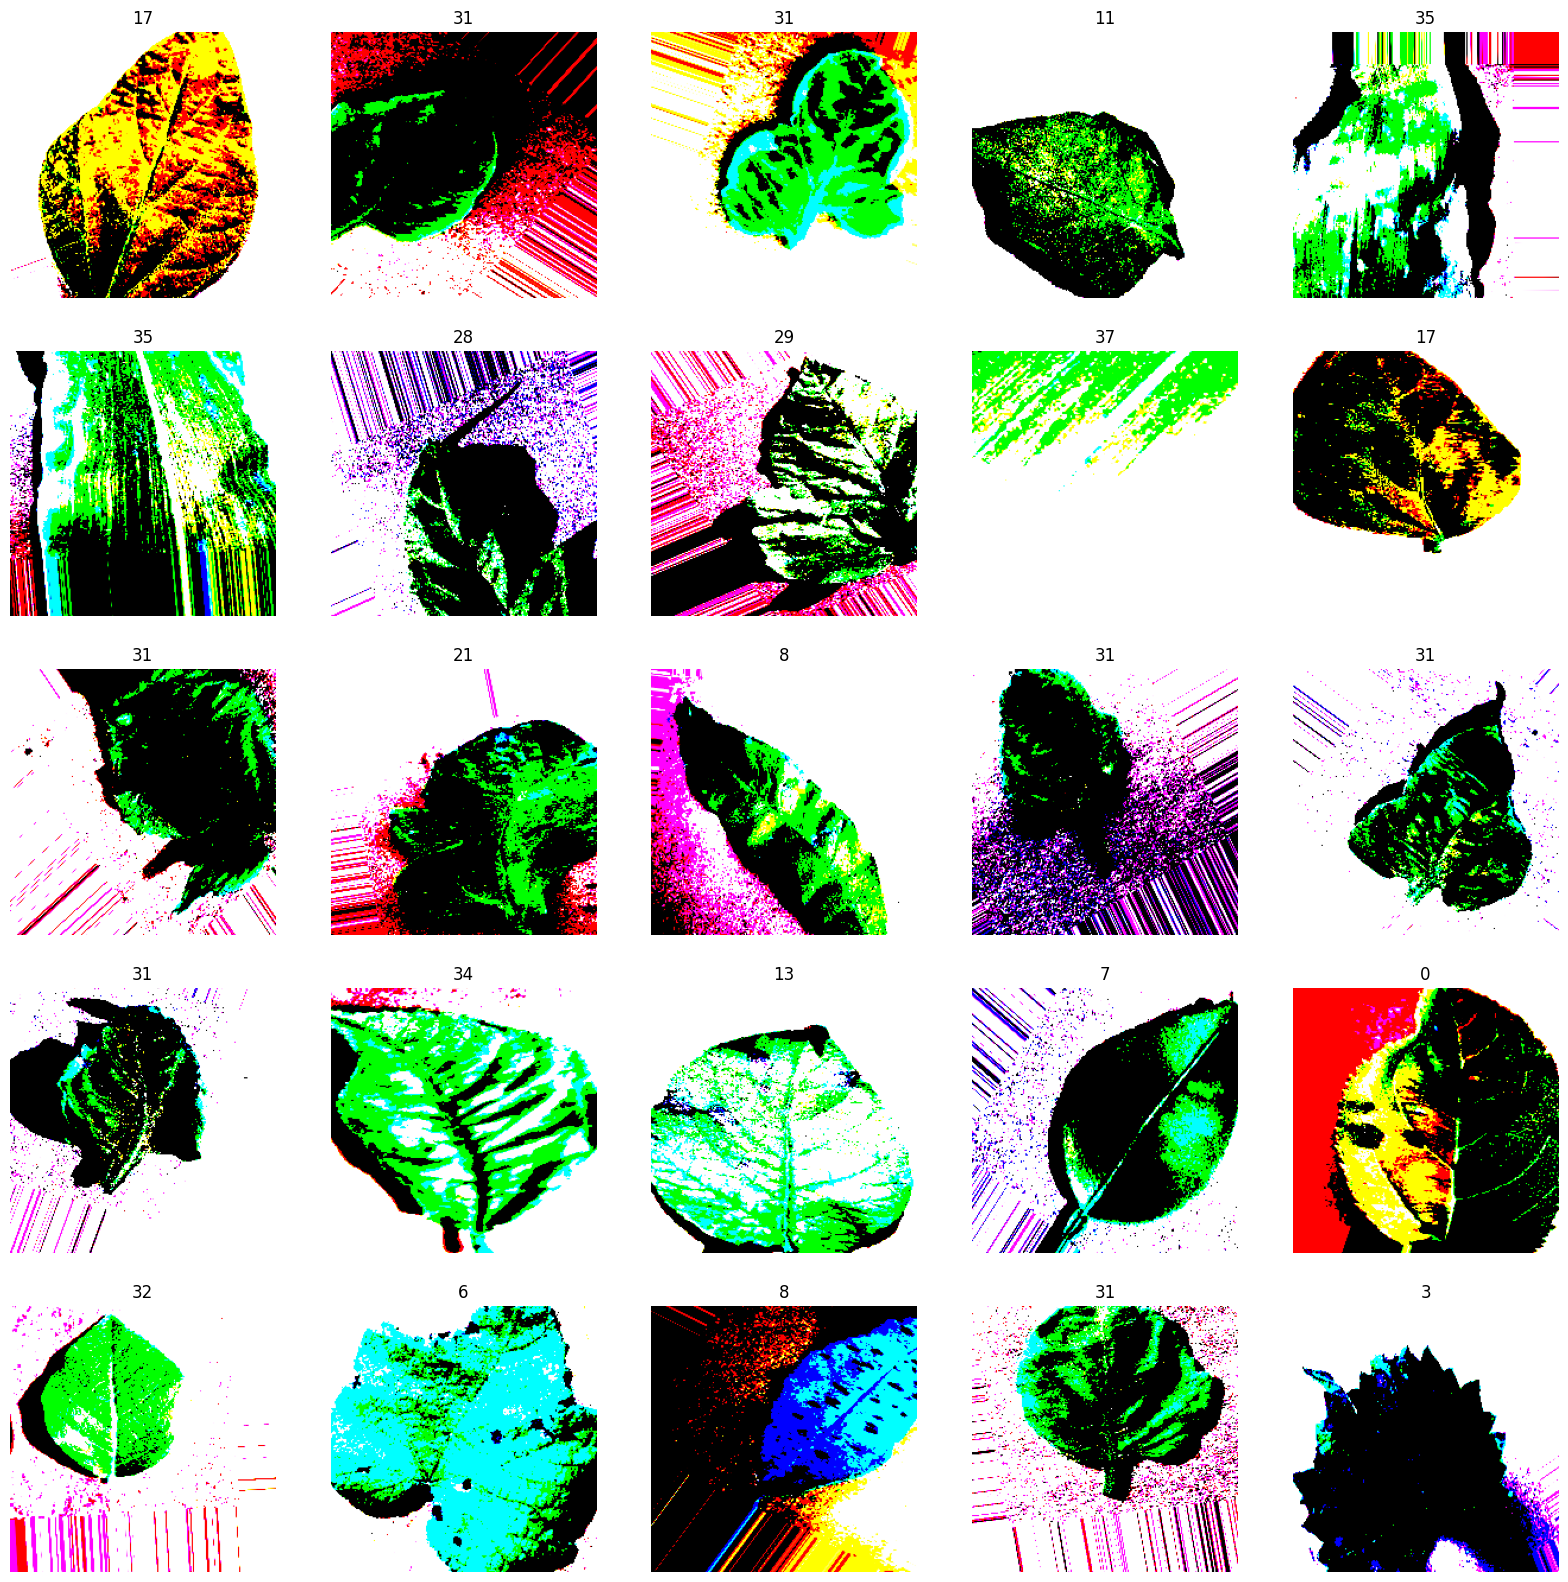

In [7]:
train, val, test = Generate_model().Data_Generator()
fig, axes = plt.subplots(5, 5, figsize= (20, 20))
for i, ax in enumerate(axes.flatten()):
    ax.set_title(np.argmax(train[0][1][i]))
    ax.imshow(train[0][0][i])
    ax.axis('off')
    
plt.show()

In [ ]:
Version = 'VGG16'
iterate_ = next(iterate)

mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment(experiment_name=Version)
mlflow.start_run(run_name=f"run_{iterate_}")
mlflow.tensorflow.autolog()

model_generator = Generate_model(Version=Version, Input_shape=(224, 224, 3), Batch_size=32, lr=1e-4, iterate=iterate_)
train, val, test = model_generator.Data_Generator()
model, history, summary = model_generator.train_model()

mlflow.log_artifact(f'images/Accuracy_Run({iterate_}).png')
mlflow.log_artifact(f'images/Loss_Run({iterate_}).png')
mlflow.log_artifact(f'images/Recall_Run({iterate_}).png')
mlflow.log_artifact(f'images/Prescision_Run({iterate_}).png')


train_metrics = model.evaluate(train) 
val_metrics = model.evaluate(val)

mlflow.log_metric('loss', train_metrics[0])
mlflow.log_metric('accuracy', train_metrics[1])
mlflow.log_metric('recall', train_metrics[2])
mlflow.log_metric('precision', train_metrics[3])

mlflow.log_metric('val_loss', val_metrics[0])
mlflow.log_metric('val_accuracy', val_metrics[1])
mlflow.log_metric('val_recall', val_metrics[2])
mlflow.log_metric('val_precision', val_metrics[3])

mlflow.tensorflow.log_model(model, 'model')

mlflow.end_run()

2023/07/29 22:58:25 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


Found 48874 validated image filenames belonging to 38 classes.
Found 2715 validated image filenames belonging to 38 classes.
Found 2716 validated image filenames belonging to 38 classes.
Found 48874 validated image filenames belonging to 38 classes.
Found 2715 validated image filenames belonging to 38 classes.
Found 2716 validated image filenames belonging to 38 classes.


Epoch 1/200
 604/1528 [==========>...................] - ETA: 38:24 - loss: 0.9652 - accuracy: 0.7198 - recall: 0.6376 - precision: 0.8586

In [25]:
mlflow.end_run()

In [191]:
def plot_artifacts(run_id):
    fig, axes = plt.subplots(4, 1, figsize=(50, 40))
    for i, path in enumerate(glob.glob(f'artifacts/1/{run_id}/artifacts/*.png')):
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(image)
        axes[i].axis('off')
    plt.show()

def Evaluate_metrics(run_id, train_data = train, val_data = val):
    final_model = mlflow.tensorflow.load_model(f'runs:/{run_id}/model')
    train = final_model.evaluate(train_data)
    val= final_model.evaluate(val_data)
    
    print('-' * 50)
    print('-' * 50)

    print(f'Train Loss: {train[0]}\nTrain Accuracy: {train[1]}\nTrain Recall: {train[2]}\nTrain Precision: {train[3]}')
    
    print('-' * 50)
    print('-' * 50)

    print(f'Validation Loss: {val[0]}\nValidation Accuracy: {val[1]}\nValidation Recall: {val[2]}\nValidation Precision: {val[3]}')
    
    print('-' * 50)
    print('-' * 50)

    return final_model


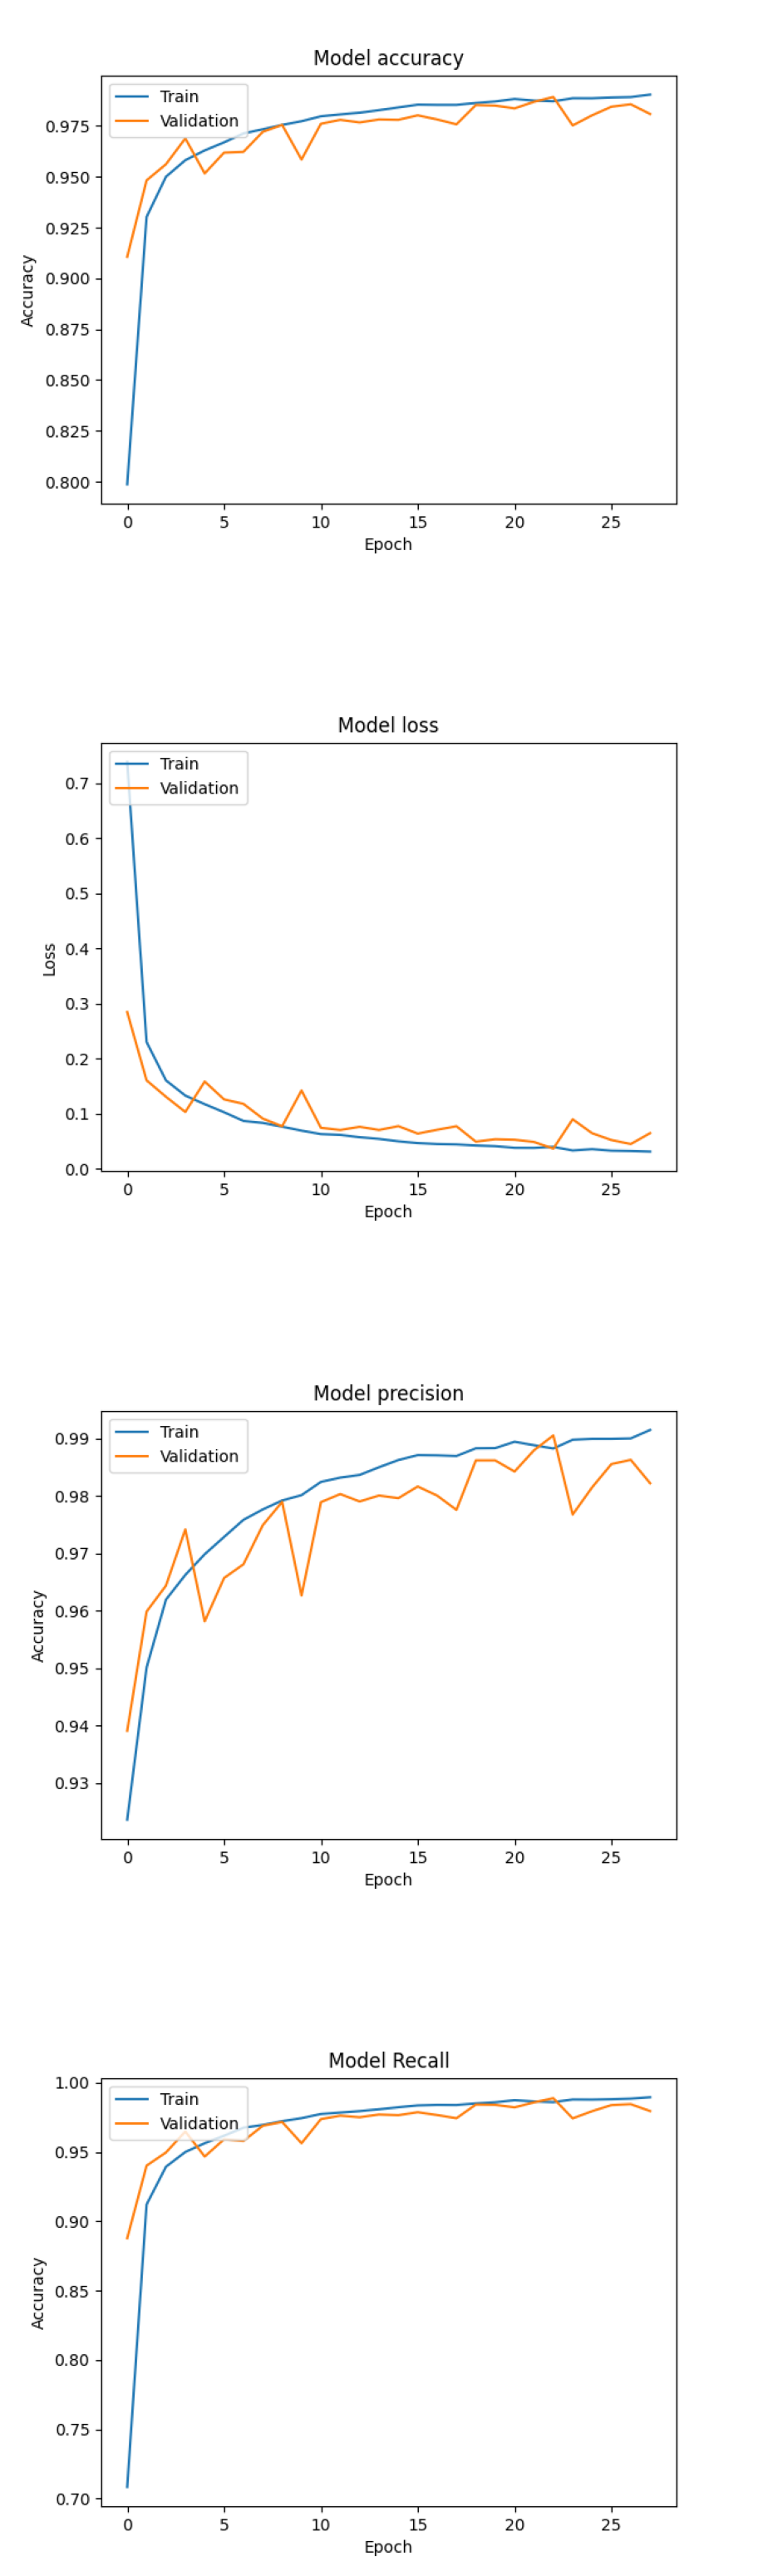

In [193]:
plot_artifacts('dab211eb3b124cc5b5727716f8089dc7')

In [194]:
final_model = Evaluate_metrics('dab211eb3b124cc5b5727716f8089dc7')

340/340 [==============================] - 86s 251ms/step - loss: 0.0380 - accuracy: 0.9887 - recall: 0.9877 - precision: 0.9892
--------------------------------------------------
--------------------------------------------------
Train Loss: 0.016036218032240868
Train Accuracy: 0.9947533011436462
Train Recall: 0.9942930936813354
Train Precision: 0.9951174855232239
--------------------------------------------------
--------------------------------------------------
Validation Loss: 0.03795483335852623
Validation Accuracy: 0.9886625409126282
Validation Recall: 0.9877408146858215
Validation Precision: 0.9891996383666992
--------------------------------------------------
--------------------------------------------------


1/1 [==============================] - 0s 18ms/step
0


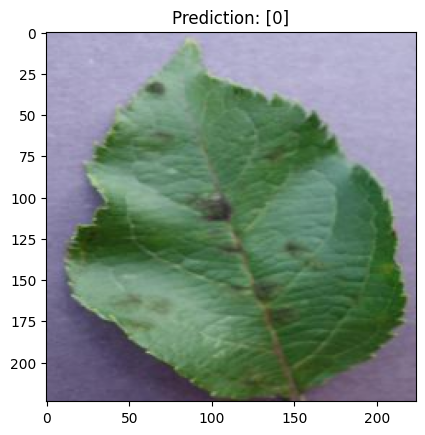

In [269]:
clss = list(train.class_indices.keys())
img = cv2.imread('plantvillage dataset/color/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224,224))
plt.imshow(img)
img =np.expand_dims(img,axis=0) 
img = preprocess_input(img)
preds = model.predict(img)
print(np.argmax(preds))
plt.title(f'Prediction: {clss[np.argmax(preds)]}')
plt.show()
# img.shape

In [268]:
list(train.class_indices.keys())[12]

'2'